In [1]:
from IPython.display import clear_output
!pip install cleverhans
clear_output()

In [2]:
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from torch.optim.lr_scheduler import StepLR

import torchvision.transforms as transforms
import torchvision.datasets as datasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train_transform = transforms.Compose([transforms.ToTensor()])

train_set = datasets.CIFAR10(root='../data/', train=True, download=True, transform=train_transform)
print(train_set.data.shape)
print(train_set.data.mean(axis=(0, 1, 2)) / 255)
print(train_set.data.std(axis=(0, 1, 2)) / 255)

100%|██████████| 170498071/170498071 [00:03<00:00, 49806667.23it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data/
(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [4]:
batch_size = 128

mean = [0.49139968, 0.48215841, 0.44653091]
std = [0.24703223, 0.24348513, 0.26158784]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

CLASSES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

In [23]:
def denormalize(img, mean, std):
    img = img.numpy().transpose((1, 2, 0))
    img = img * std + mean
    return np.clip(img, 0, 1)

def show_samples(data_loader):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images[:5]
    labels = labels[:5]
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, ax in enumerate(axes):
        img = denormalize(images[i], mean, std)
        ax.imshow(img)
        ax.set_title(f"{CLASSES[labels[i].item()]}", fontsize=20)
        ax.axis("off")
    plt.show()

def show_adv_images_with_labels(adv_examples, true_labels, pred_labels_orig, pred_labels_adv):
    orig_images, adv_images = adv_examples[0]  # Example batch
    fig, axes = plt.subplots(3, 5, figsize=(15, 8))
    for i in range(5):
        orig = denormalize(orig_images[i].detach().cpu(), mean, std)
        adv = denormalize(adv_images[i].detach().cpu(), mean, std)
        diff = np.abs(adv - orig)

        true_label = CLASSES[true_labels[i]]
        orig_pred_label = CLASSES[pred_labels_orig[i]]
        adv_pred_label = CLASSES[pred_labels_adv[i]]

        axes[0, i].imshow(orig)
        axes[0, i].set_title(f"True: {true_label}\nPred: {orig_pred_label}")
        axes[0, i].axis("off")
        axes[1, i].imshow(adv)
        axes[1, i].set_title(f"Adversarial\nPred: {adv_pred_label}")
        axes[1, i].axis("off")
        axes[2, i].imshow(diff)
        axes[2, i].set_title("Difference")
        axes[2, i].axis("off")
    plt.tight_layout()
    plt.show()

def visualize_adversarial_samples(generator, test_loader):
    generator.eval()

    images, labels = next(iter(test_loader))
    images, labels = images[:5].to(device), labels[:5].to(device)
    with torch.no_grad():
        perturbations = generator(images)
        adv_images = torch.clamp(images + perturbations, -1, 1)

    images = images.cpu()
    adv_images = adv_images.cpu()
    perturbations = perturbations.cpu()

    fig, axes = plt.subplots(3, 5, figsize=(15, 8))
    for i in range(5):
        axes[0, i].imshow(denormalize(images[i], mean, std))
        axes[0, i].set_title(f"Original: {CLASSES[labels[i]]}")
        axes[0, i].axis("off")
        axes[1, i].imshow(denormalize(adv_images[i], mean, std))
        axes[1, i].set_title("Adversarial")
        axes[1, i].axis("off")
        axes[2, i].imshow(denormalize(perturbations[i], mean, std), cmap="seismic")
        axes[2, i].set_title("Perturbation")
        axes[2, i].axis("off")
    plt.tight_layout()
    plt.show()

def plot_losses(epochs, g_losses, d_losses, g_accuracies):
    actual_epochs = len(g_losses)  # Number of completed epochs
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, actual_epochs + 1), g_losses, label='Generator Loss', color='blue')
    plt.plot(range(1, actual_epochs + 1), d_losses, label='Discriminator Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, actual_epochs + 1), g_accuracies, label='Generator Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Generator Fooling Accuracy')
    plt.legend()    
    plt.tight_layout()
    plt.show()


def plot_confidence_histograms(target_model, test_loader, generator):
    normal_confidences = []
    adversarial_confidences = []

    generator.eval()
    target_model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            perturbations = generator(images)
            adv_images = torch.clamp(images + perturbations, -1, 1)
            # Get softmax confidence for normal and adversarial images
            normal_outputs = torch.softmax(target_model(images), dim=1)
            adv_outputs = torch.softmax(target_model(adv_images), dim=1)

            normal_confidences.extend(normal_outputs.max(1)[0].cpu().numpy())
            adversarial_confidences.extend(adv_outputs.max(1)[0].cpu().numpy())
    plt.figure(figsize=(10, 5))
    plt.hist(adversarial_confidences, bins=20, alpha=0.7, label="Adversarial Samples", color="red")
    plt.hist(normal_confidences, bins=20, alpha=0.7, label="Normal Samples", color="blue")
    plt.xlabel("Confidence")
    plt.ylabel("Frequency")
    plt.title("Confidence Histogram: Normal vs Adversarial")
    plt.legend()
    plt.show()

In [6]:
def attack_success_rate(model, adv_examples):
    total, success = 0, 0
    model.eval()
    for orig_images, adv_images in adv_examples:
        with torch.no_grad():
            orig_preds = model(orig_images).argmax(dim=1)
            adv_preds = model(adv_images).argmax(dim=1)
            success += (orig_preds != adv_preds).sum().item()
            total += orig_images.size(0)
    return success / total

def calculate_attack_success(target_model, test_loader, generator):
    overall_success = 0
    per_class_success = np.zeros(10)
    per_class_count = np.zeros(10)

    generator.eval()
    target_model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            perturbations = generator(images)
            adv_images = torch.clamp(images + perturbations, -1, 1)
            # Get predictions on adversarial samples
            adv_outputs = target_model(adv_images)
            _, adv_preds = adv_outputs.max(1)
            fooled = (adv_preds != labels).cpu().numpy()
            overall_success += fooled.sum()
            for label, is_fooled in zip(labels.cpu().numpy(), fooled):
                per_class_count[label] += 1
                per_class_success[label] += is_fooled
    overall_rate = overall_success / sum(per_class_count)
    per_class_rate = per_class_success / per_class_count
    return overall_rate, per_class_rate

def calculate_targeted_attack_success(target_model, test_loader, generator, target_class):
    overall_success = 0
    per_class_success = np.zeros(10)
    per_class_count = np.zeros(10)

    generator.eval()
    target_model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            perturbations = generator(images)
            adv_images = torch.clamp(images + perturbations, -1, 1)

            # Get predictions on adversarial samples
            adv_outputs = target_model(adv_images)
            _, adv_preds = adv_outputs.max(1)

            # Check if target model was successfully targeted
            targeted = (adv_preds == target_class).cpu().numpy()
            overall_success += targeted.sum()

            # Update per-class metrics
            for label, is_targeted in zip(labels.cpu().numpy(), targeted):
                per_class_count[label] += 1
                per_class_success[label] += is_targeted

    overall_rate = overall_success / sum(per_class_count)
    per_class_rate = per_class_success / per_class_count

    return overall_rate, per_class_rate

In [7]:
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
print(dataset.data.shape)
print(dataset.data.mean(axis=(0, 1, 2)) / 255)
print(dataset.data.std(axis=(0, 1, 2)) / 255)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Split training dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 49179213.12it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]
Files already downloaded and verified


In [8]:
# show_samples(train_loader)
# show_samples(val_loader)
# show_samples(test_loader)

In [9]:
target_model = torch.hub.load(
    "chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True
).to(device)
target_model.eval()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|██████████| 1.09M/1.09M [00:00<00:00, 34.4MB/s

CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [10]:
# Evaluate accuracy on test set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = target_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total}%")

Test Accuracy: 92.12%


In [11]:
# # Generate adversarial images using FGSM
# epsilon = 0.01

# adv_examples = []
# true_labels = []
# pred_labels_orig = []
# pred_labels_adv = []

# target_model.eval()
# for images, labels in test_loader:
#     images, labels = images.to(device), labels.to(device)

#     adv_images = fast_gradient_method(target_model, images, epsilon, norm=np.inf)
#     adv_examples.append((images, adv_images))
#     true_labels.extend(labels.cpu().numpy())
    
#     with torch.no_grad():
#         orig_preds = target_model(images).argmax(dim=1)
#         adv_preds = target_model(adv_images).argmax(dim=1)
#         pred_labels_orig.extend(orig_preds.cpu().numpy())
#         pred_labels_adv.extend(adv_preds.cpu().numpy())

# success_rate = attack_success_rate(target_model, adv_examples)
# print(f"Attack Success Rate: {success_rate * 100:.2f}%")

In [12]:
# show_samples(train_loader)
# show_samples(val_loader)
# show_samples(test_loader)

In [13]:
# show_adv_images_with_labels(adv_examples, true_labels, pred_labels_orig, pred_labels_adv)

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, kernel_size=8),  # 8x8 -> 1x1
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x).view(-1)



cross_entropy = nn.CrossEntropyLoss()

# class LossFunctions:
#     @staticmethod
#     def adversarial_loss(target_model, cross_entropy, x, perturbation):
#         x_adv = x + perturbation
#         target_labels = torch.argmax(target_model(x_adv), dim=1)
#         return cross_entropy(target_model(x_adv), target_labels)

#     @staticmethod
#     def gan_loss(discriminator, x, perturbation):
#         real_loss = torch.log(discriminator(x) + 1e-8).mean()
#         fake_loss = torch.log(1 - discriminator(x + perturbation) + 1e-8).mean()
#         return -(real_loss + fake_loss)

#     @staticmethod
#     def hinge_loss(perturbation, c):
#         norm = torch.norm(perturbation.view(perturbation.size(0), -1), p=2, dim=1)
#         hinge = torch.clamp(norm - c, min=0)
#         return hinge.mean()

#     @staticmethod
#     def total_loss(discriminator, target_model, cross_entropy, alpha, beta, c, x, perturbation):
#         adv_loss = LossFunctions.adversarial_loss(target_model, cross_entropy, x, perturbation)
#         gan_loss = LossFunctions.gan_loss(discriminator, x, perturbation)
#         hinge_loss = LossFunctions.hinge_loss(perturbation, c)
#         return adv_loss + alpha * gan_loss + beta * hinge_loss

class LossFunctions:
    @staticmethod
    def adversarial_loss(target_model, cross_entropy, x, perturbation):
        x_adv = x + perturbation
        adv_predictions = target_model(x_adv)
        target_labels = torch.argmax(adv_predictions.detach(), dim=1)  # Detach to avoid graph reuse
        return cross_entropy(adv_predictions, target_labels)

    @staticmethod
    def gan_loss(discriminator, x, perturbation):
        real_loss = torch.log(discriminator(x) + 1e-8).mean()
        fake_loss = torch.log(1 - discriminator(x + perturbation.detach()) + 1e-8).mean()
        return -(real_loss + fake_loss)

    @staticmethod
    def hinge_loss(perturbation, c):
        norm = torch.norm(perturbation.view(perturbation.size(0), -1), p=2, dim=1)
        hinge = torch.clamp(norm - c, min=0)
        return hinge.mean()

    @staticmethod
    def total_loss(discriminator, target_model, cross_entropy, alpha, beta, c, x, perturbation):
        adv_loss = LossFunctions.adversarial_loss(target_model, cross_entropy, x, perturbation)
        gan_loss = LossFunctions.gan_loss(discriminator, x, perturbation)
        hinge_loss = LossFunctions.hinge_loss(perturbation, c)
        return adv_loss + alpha * gan_loss + beta * hinge_loss

In [15]:
def train_gan(
    generator, discriminator, target_model, train_loader, 
    epochs, g_optimizer, d_optimizer, c, alpha, beta, 
    g_scheduler, d_scheduler, patience
):
    g_losses, d_losses, g_accuracies = [], [], []
    best_g_loss, best_d_loss = float('inf'), float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        g_loss_epoch, d_loss_epoch = 0.0, 0.0
        correct_adv, total_samples = 0, 0
        tepoch = tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{epochs}", ncols=100, leave=False)

        generator.train()
        discriminator.train()
        for batch_idx, (images, labels) in enumerate(tepoch):
            images, labels = images.to(device), labels.to(device)

            perturbations = generator(images)
            adv_images = torch.clamp(images + perturbations, -1, 1)

            d_optimizer.zero_grad()
            d_loss = LossFunctions.gan_loss(
                discriminator, images, perturbations
            )
            d_loss.backward()
            d_optimizer.step()

            g_optimizer.zero_grad()
            g_loss = LossFunctions.total_loss(
                discriminator, target_model, cross_entropy, 
                alpha, beta, c, images, perturbations
            )
            # g_loss.backward()
            g_loss.backward()
            g_optimizer.step()

            g_loss_epoch += g_loss.item()
            d_loss_epoch += d_loss.item()
            adv_output = target_model(adv_images)
            _, predicted = adv_output.max(1)
            correct_adv += (predicted != labels).sum().item()
            total_samples += labels.size(0)
            tepoch.set_postfix({'Batch': batch_idx + 1, 'G_Loss': g_loss.item(), 'D_Loss': d_loss.item()})

        g_losses.append(g_loss_epoch / len(train_loader))
        d_losses.append(d_loss_epoch / len(train_loader))
        g_accuracies.append(correct_adv / total_samples)

        print(f"Epoch [{epoch+1}/{epochs}], Generator Loss: {g_losses[-1]:.4f}, Discriminator Loss: {d_losses[-1]:.4f}, Fooling Accuracy: {g_accuracies[-1]:.4f}")
        generator.eval()
        discriminator.eval()
        g_scheduler.step()
        d_scheduler.step()

        if g_losses[-1] < best_g_loss or d_losses[-1] < best_d_loss:
            best_g_loss = min(g_losses[-1], best_g_loss)
            best_d_loss = min(d_losses[-1], best_d_loss)
            epochs_no_improve = 0
        else:
            print(f"Epochs without improvement: {epochs_no_improve + 1}/{patience}")
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

    return g_losses, d_losses, g_accuracies


In [16]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

epochs = 50 
lr = 0.001
alpha = 1.0 # param alpha: Weight for adversarial loss (LGAN) 
beta = 10.0 # param beta: Weight for hinge loss (Lhinge)
c = 8/255   # param c: Hinge loss bound
patience = 5

g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

g_scheduler = StepLR(g_optimizer, step_size=10, gamma=0.5)
d_scheduler = StepLR(d_optimizer, step_size=10, gamma=0.5)

In [17]:
g_losses, d_losses, g_accuracies = train_gan(
    generator, discriminator, target_model, train_loader, 
    epochs, g_optimizer, d_optimizer, c, alpha, beta, 
    g_scheduler, d_scheduler, patience
)

Epoch [1/50], Generator Loss: 30.2678, Discriminator Loss: 1.2268, Fooling Accuracy: 0.1130


Epoch [2/50], Generator Loss: 9.1913, Discriminator Loss: 1.0577, Fooling Accuracy: 0.0939


Epoch [3/50], Generator Loss: 5.7951, Discriminator Loss: 0.8912, Fooling Accuracy: 0.0931


Epoch [4/50], Generator Loss: 4.7707, Discriminator Loss: 0.7349, Fooling Accuracy: 0.0919


Epoch [5/50], Generator Loss: 4.1993, Discriminator Loss: 0.6178, Fooling Accuracy: 0.0920


Epoch [6/50], Generator Loss: 4.4817, Discriminator Loss: 0.6517, Fooling Accuracy: 0.0921
Epochs without improvement: 1/5


Epoch [7/50], Generator Loss: 3.4392, Discriminator Loss: 0.5658, Fooling Accuracy: 0.0906


Epoch [8/50], Generator Loss: 3.1805, Discriminator Loss: 0.4589, Fooling Accuracy: 0.0907


Epoch [9/50], Generator Loss: 3.4339, Discriminator Loss: 0.5687, Fooling Accuracy: 0.0909
Epochs without improvement: 1/5


Epoch [10/50], Generator Loss: 2.8480, Discriminator Loss: 0.5409, Fooling Accuracy: 0.0895


Epoch [11/50], Generator Loss: 1.5250, Discriminator Loss: 0.6714, Fooling Accuracy: 0.0885


Epoch [12/50], Generator Loss: 1.2989, Discriminator Loss: 0.5638, Fooling Accuracy: 0.0885


Epoch [13/50], Generator Loss: 1.4364, Discriminator Loss: 0.5227, Fooling Accuracy: 0.0882
Epochs without improvement: 1/5


Epoch [14/50], Generator Loss: 1.3433, Discriminator Loss: 0.5100, Fooling Accuracy: 0.0889
Epochs without improvement: 2/5


Epoch [15/50], Generator Loss: 1.6482, Discriminator Loss: 0.5673, Fooling Accuracy: 0.0891
Epochs without improvement: 3/5


Epoch [16/50], Generator Loss: 1.5088, Discriminator Loss: 0.5280, Fooling Accuracy: 0.0892
Epochs without improvement: 4/5


Epoch [17/50], Generator Loss: 1.5635, Discriminator Loss: 0.4933, Fooling Accuracy: 0.0886
Epochs without improvement: 5/5
Early stopping triggered after 17 epochs.


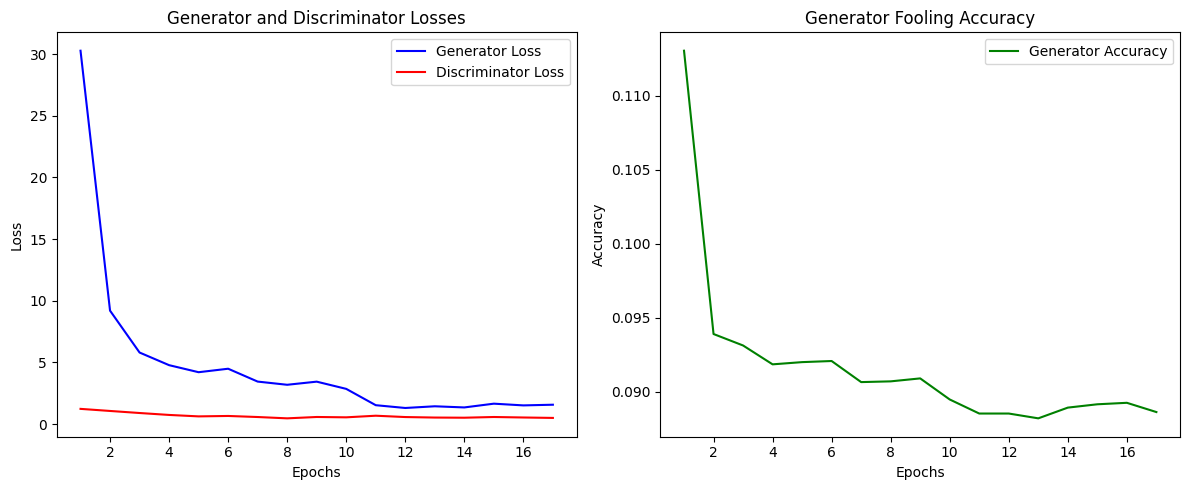

In [24]:
plot_losses(epochs, g_losses, d_losses, g_accuracies)

In [25]:
overall_rate, per_class_rate = calculate_attack_success(target_model, test_loader, generator)

print(f"Overall Attack Success Rate: {overall_rate * 100:.2f}%")
for i, class_name in enumerate(CLASSES):
    print(f"Class {class_name}: {per_class_rate[i] * 100:.2f}%")

Overall Attack Success Rate: 15.77%
Class airplane: 9.40%
Class automobile: 10.40%
Class bird: 12.40%
Class cat: 27.90%
Class deer: 11.20%
Class dog: 29.70%
Class frog: 10.90%
Class horse: 16.50%
Class ship: 10.20%
Class truck: 19.10%


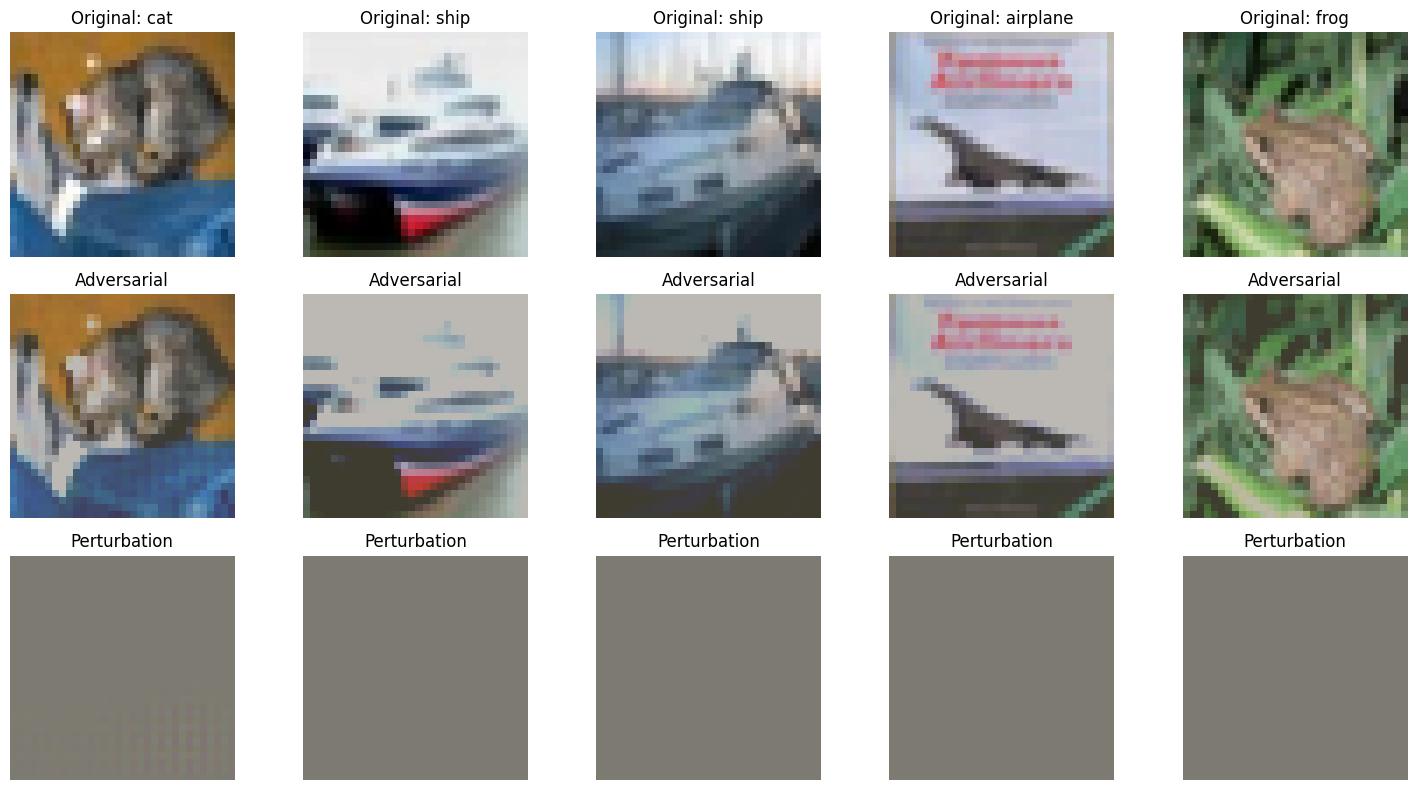

In [27]:
visualize_adversarial_samples(generator, test_loader)

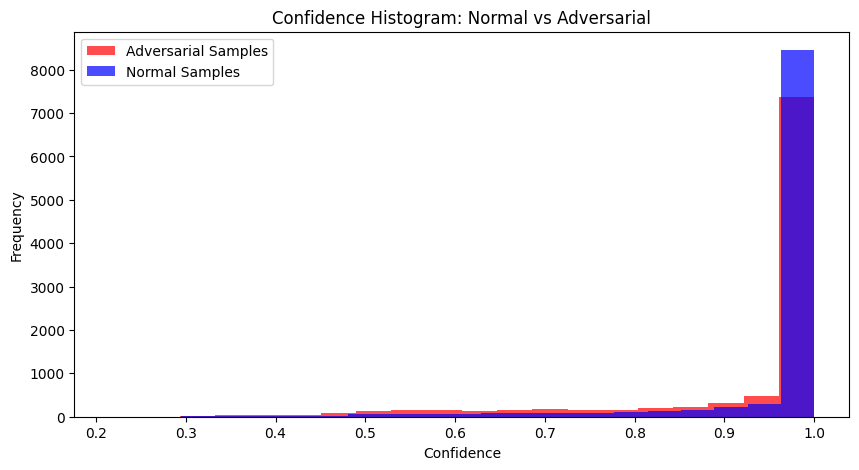

In [28]:
plot_confidence_histograms(target_model, test_loader, generator)

In [ ]:
# target_class = 0  # Example: Force adversarial images to be classified as "airplane" (class 0)
# fooling_loss = adv_loss_fn(adv_output, torch.full_like(labels, target_class))

# generator = Generator().to(device)
# discriminator = Discriminator().to(device)

# epochs = 50 
# lr = 0.001
# alpha = 1.0  # Weight for GAN loss
# beta = 10.0  # Weight for hinge loss
# # c = 0.1  # Perturbation bound
# c = 8/255 # Perturbation bound (c) = 8/255 for CIFAR-10

# g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
# d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# g_scheduler = StepLR(g_optimizer, step_size=10, gamma=0.5)
# d_scheduler = StepLR(d_optimizer, step_size=10, gamma=0.5)

# g_losses, d_losses, g_accuracies = train_gan(
#     generator, discriminator, target_model, train_loader, 
#     epochs, g_optimizer, d_optimizer, c, alpha, beta, 
#     g_scheduler, d_scheduler, patience
# )

# plot_losses(epochs, g_losses, d_losses, g_accuracies)
# overall_rate, per_class_rate = calculate_targeted_attack_success(target_model, test_loader, generator, target_class)

# print(f"Overall Targeted Attack Success Rate: {overall_rate * 100:.2f}%")
# for i, class_name in enumerate(CLASSES):
#     print(f"Class {class_name}: {per_class_rate[i] * 100:.2f}%")

# visualize_adversarial_samples(generator, test_loader)
# plot_confidence_histograms(target_model, test_loader, generator)